In [1]:
from gpt.utils import set_seed, setup_logging, CfgNode as CN
from gpt.model import GPT
import os
import matplotlib.pyplot as plt
import torch
from gpt.dataset import NewPairedData
import numpy as np

def get_config():

    C = CN()

    # system
    C.system = CN()
    C.system.seed = 3407
    C.system.work_dir = './out/new_data'

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt-mini'

    return C


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device is {device}')

config = get_config()
print(config)
test_dataset = NewPairedData(train=True)
config.model.block_size = test_dataset.get_block_size()
config.model.scores_size = test_dataset.get_scores_length()
config.model.far_reco_size = test_dataset.get_far_reco_length()


model = GPT(config.model)
model.load_state_dict(torch.load(os.path.join(config.system.work_dir, 'model.pt')))
model = model.eval()

Device is cuda
system:
    seed: 3407
    work_dir: ./out/new_data
model:
    model_type: gpt-mini
    n_layer: None
    n_head: None
    n_embd: None
    n_gaussians: 42
    vocab_size: None
    block_size: None
    scores_size: None
    far_reco_size: None
    embd_pdrop: 0.0
    resid_pdrop: 0.1
    attn_pdrop: 0.1

number of parameters: 2.67M


In [2]:
test_dataset = NewPairedData(train=False)

import pandas as pd
import seaborn as sns

def get_df(pred_x, true_x=None):
    col_names = test_dataset.near_reco + test_dataset.cvn_scores + test_dataset.far_reco 
    assert len(col_names) == pred_x.shape[1]
    df = pd.DataFrame(pred_x, columns=col_names)
    df['class'] = 'predicted'
    df_true = pd.DataFrame(true_x, columns=col_names)

    if true_x is not None: 
        assert len(col_names) == true_x.shape[1]
        df_true['class'] = 'true'
        df = pd.concat([df, df_true])
    return df

In [3]:
batch_size = 20_000
num_iter = 9
model = model.to(device)

pred_list = []
for i in range(num_iter):
    idx = torch.tensor(test_dataset.data[:, :len(test_dataset.near_reco)], dtype=torch.float).to(device)[i*batch_size:(i+1)*batch_size]
    pred = model.generate(idx, device='cuda').cpu().numpy()
    pred_list.append(pred)
pred = np.concatenate(pred_list)

df = get_df(pred, test_dataset.data[:len(pred), :])

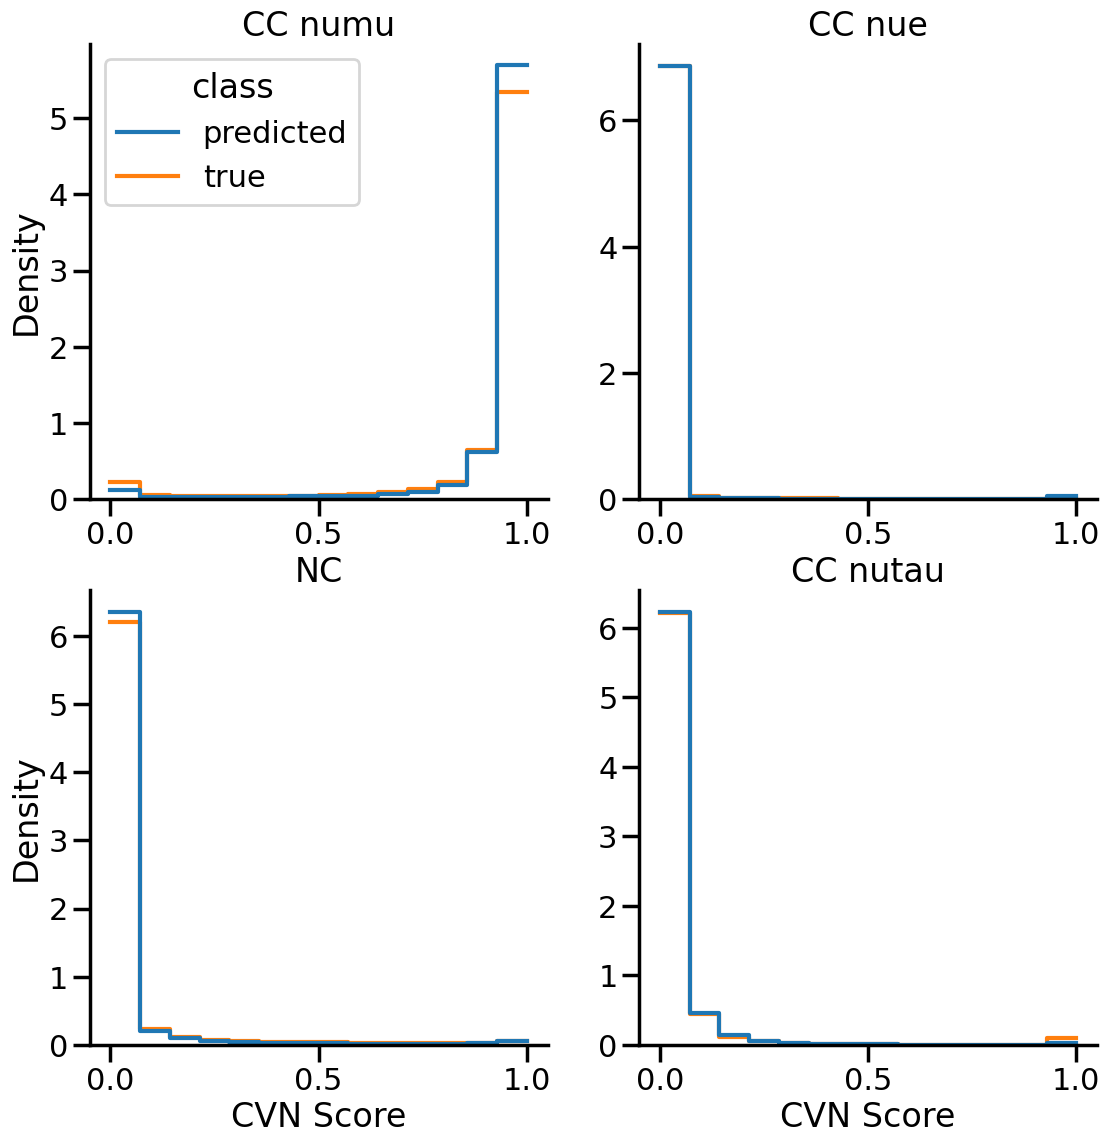

In [ ]:
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_context('poster')
bins = np.linspace(0.0, 1.0, 15)
fig, ax = plt.subplots(2, 2, figsize=(13, 13)) #figsize=(10, 10)
sns.histplot(data=df, x='fd_numu_score', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[0, 0], fill=False, legend=True)
ax[0, 0].set_title('CC numu')
ax[0, 0].set_xlabel('')
sns.histplot(data=df, x='fd_nue_score', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[0, 1], fill=False, legend=False)
ax[0, 1].set_title('CC nue')
ax[0, 1].set_xlabel('CVN Score')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')
sns.histplot(data=df, x='fd_nc_score', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[1, 0], fill=False, legend=False)
ax[1, 0].set_title('NC')
ax[1, 0].set_xlabel('CVN Score')
sns.histplot(data=df, x='fd_nutau_score', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[1, 1], fill=False, legend=False)
ax[1, 1].set_title('CC nutau')
ax[1, 1].set_ylabel('')
ax[1, 1].set_xlabel('CVN Score')
sns.despine()

ValueError: cannot reindex on an axis with duplicate labels

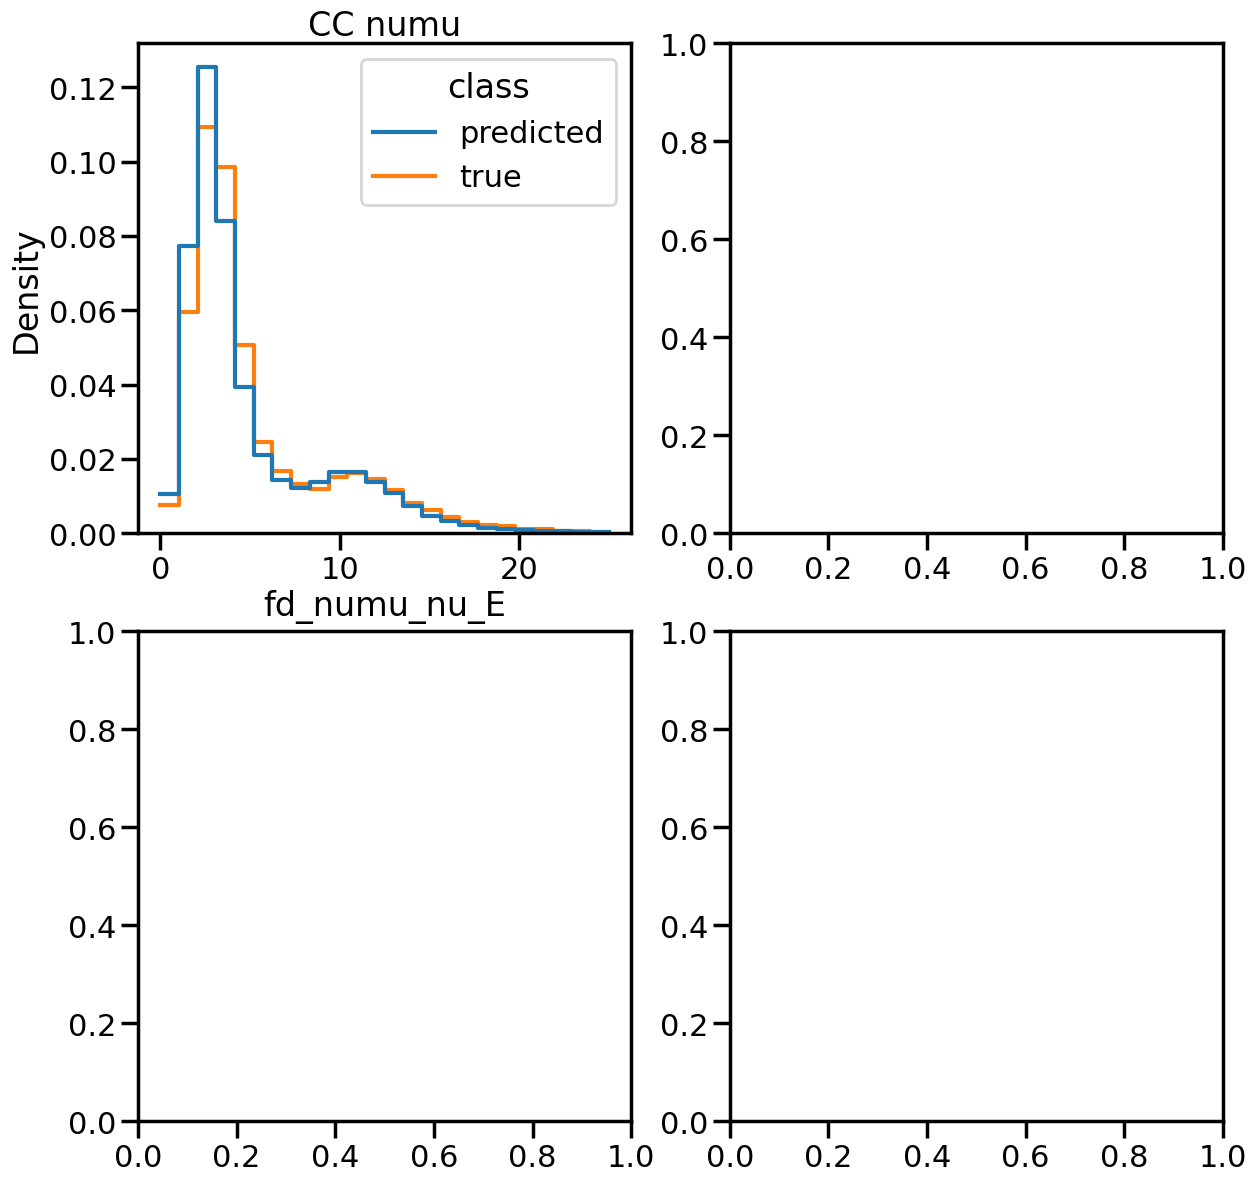

In [ ]:
bins = np.linspace(0, 25, 25)

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

#['fd_numu_nu_E', 'fd_nue_nu_E', 'fd_numu_lep_E', 'fd_nue_lep_E' 

sns.histplot(data=df, x='fd_numu_nu_E', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[0, 0], fill=False, legend=True)
ax[0, 0].set_title('CC numu')

sns.histplot(data=df, x='fd_nue_nu_E', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[0, 1], fill=False, legend=False)
ax[0, 1].set_title('CC nue')

sns.histplot(data=df, x='fd_numu_lep_E', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[1, 0], fill=False, legend=False)
ax[1, 0].set_title('CC numu')

sns.histplot(data=df, x='fd_nue_lep_E', hue='class', stat='density', element='step', common_norm=True, bins=bins, ax=ax[1, 1], fill=False, legend=False)
ax[1, 1].set_title('CC nue')

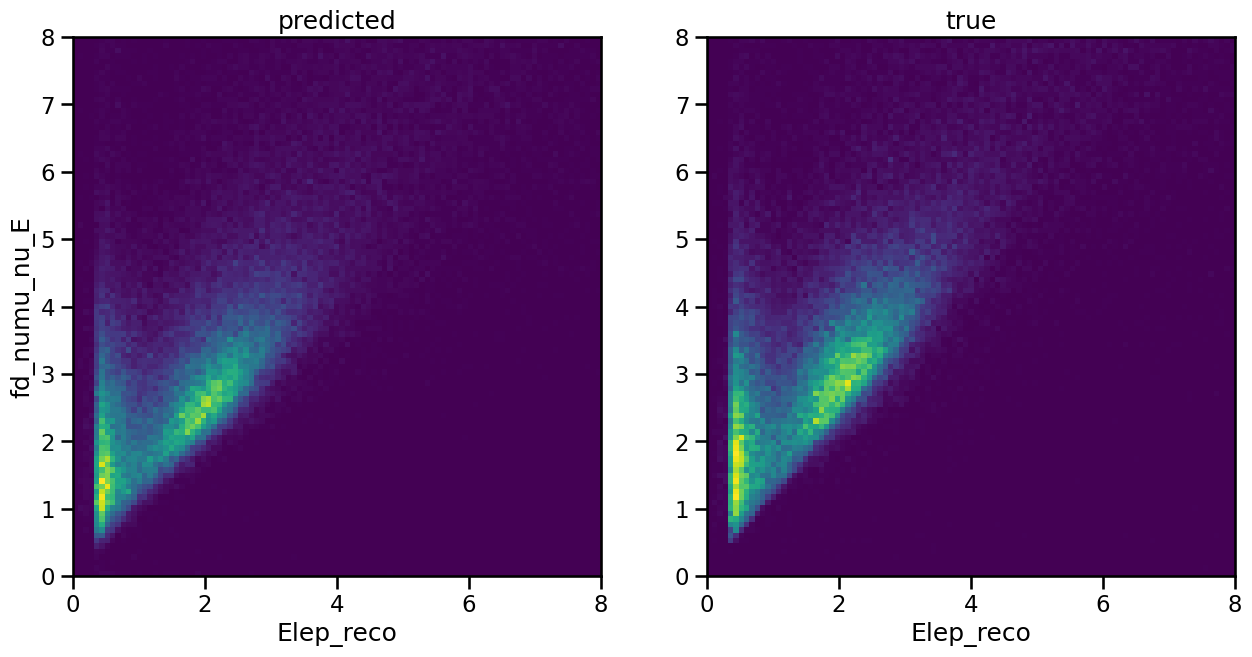

In [ ]:
sns.set_context('talk')
def by_name(name, x):
    """Select column by name"""
    index = df.columns.get_loc(name)
    return x[:, index]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

y_col = 'fd_numu_nu_E' #'eRecoP', 'eRecoN', 'eRecoPip', 'eRecoPim', 'eRecoPi0', 'eRecoOther', 'Ev_reco', 'Elep_reco', 'theta_reco'            
x_col = 'Elep_reco' #'nc_lep_E', 'nc_had_E', 'nc_nu_E', 'numu_lep_E', 'numu_had_E', 'numu_nu_E', 'nue_lep_E', 'nue_had_E', 'nue_nu_E'
x = by_name(x_col, pred)
y = by_name(y_col, pred)
bins_y = np.linspace(0, 8, 100)
bins_x = np.linspace(0, 8, 100)
ax[0].hist2d(x, y, bins=(bins_x, bins_y), cmin=0)
ax[0].set_xlabel(x_col)
ax[0].set_ylabel(y_col)
ax[0].set_title('predicted')

true = test_dataset.data[:batch_size*num_iter]
x = by_name(x_col, true)
y = by_name(y_col, true)
ax[1].hist2d(x, y, bins=(bins_x, bins_y), cmin=0)
ax[1].set_xlabel(x_col)
ax[1].set_title('true')
plt.savefig(f'{x_col}_{y_col}')
